# Assignment 4

This assignment contains 4 sections:
- KMeans Segmentation
- Expectation Maximization Segmentation
- Mask-RCNN Segmentation

In [50]:
# All imports
from os.path import abspath, join
from os import listdir
from cv2 import imread, IMREAD_GRAYSCALE
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn import mixture
from gluoncv import model_zoo, data, utils

# The path to the images is the relative path in this repo `./images`
image_folder = abspath('./images')
print("image folder: " + image_folder)

image folder: /home/alix/Desktop/school/semester_5/ECSE-415/assignment4/images


/home/alix/Desktop/school/semester_5/ECSE-415/assignment4/assignment4/lib/python3.9/site-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.8.0` and `torch==1.10.0+cu102` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [51]:
def convert_color(image):
    """
    Converts opencv color ordering to matplotlib color ordering
    @param image: the color image to convert
    @returns the converted image
    """
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

## KMeans Segmentation
I just used the kmeans library because I wanted to learn about it but didn't need the points. 

Here is the implementation I found online to understand how it works internally: https://www.askpython.com/python/examples/k-means-clustering-from-scratch

In [52]:
img_color = imread(join(image_folder, 'poodle.jpg'))
img_grey = imread(join(image_folder, 'poodle.jpg'), IMREAD_GRAYSCALE)

img_color_mod = np.float32(img_color.reshape(-1, 3))
img_grey_mod = np.float32(img_grey.reshape(-1,))

### Color picture k-means segmentation

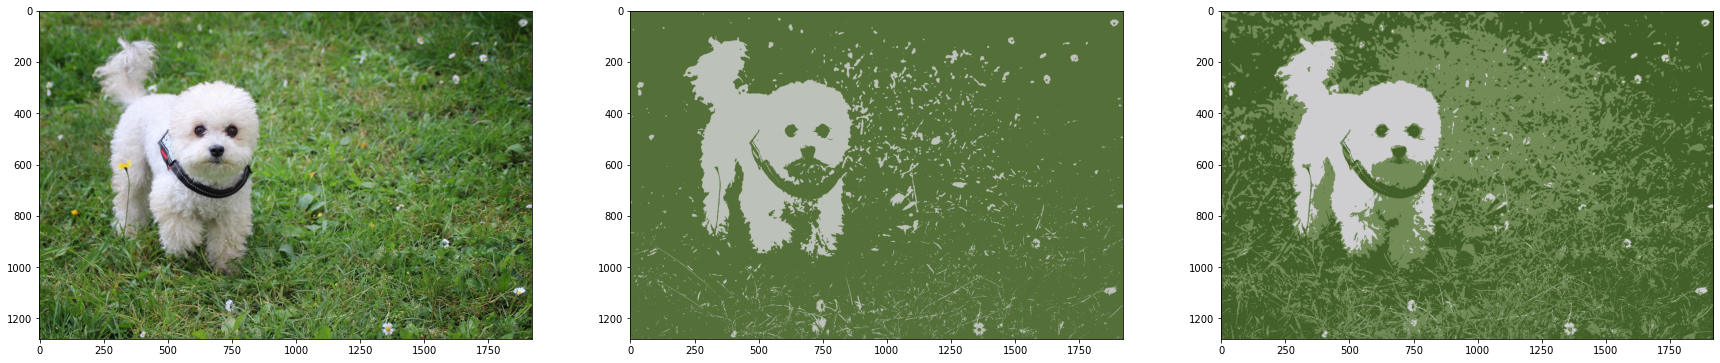

In [53]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

f, color = plt.subplots(1, 3, figsize=(30, 15))

color[0].imshow(convert_color(img_color))

for i in [2, 3]:
    ret, label, center = cv2.kmeans(img_color_mod, i, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    out = center[label.flatten()]
    color[i - 1].imshow(convert_color(out.reshape(img_color.shape)))

### Grayscale picture k-means segmentation

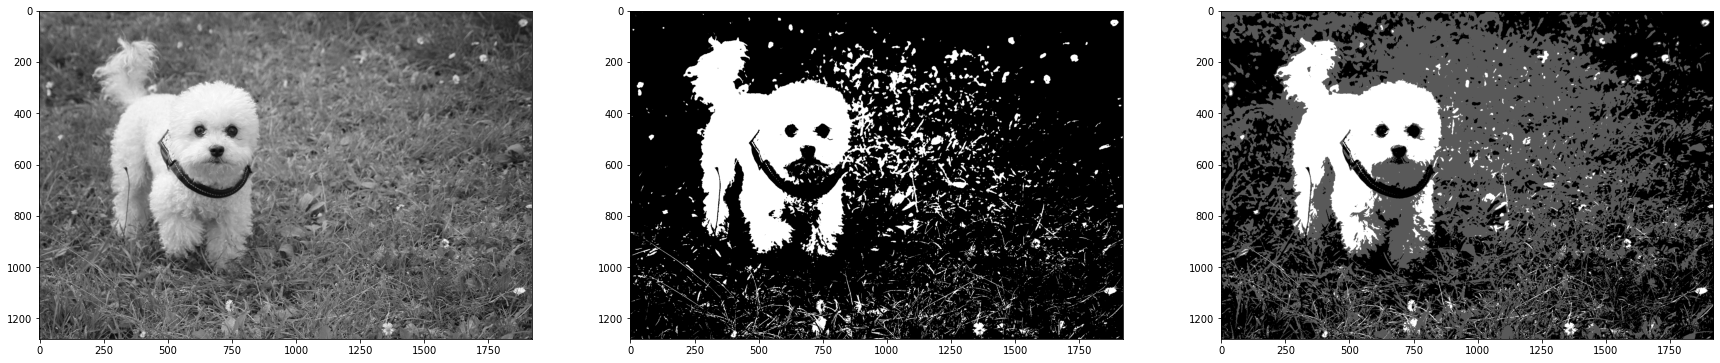

In [54]:
f, grey = plt.subplots(1, 3, figsize=(30, 15))

grey[0].imshow(img_grey, cmap='gray')

for i in [2, 3]:
    ret, label, center = cv2.kmeans(img_grey_mod, i, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    out = center[label.flatten()]
    grey[i - 1].imshow(out.reshape(img_grey.shape), cmap='gray')

The best feature choice was an RGB segmentation with K=2. A good part of the dog (paws and belly) would not have been detected because it would be the same color as the grass with K=3. RGB k-means also had less noise, because there is more distinctions because we have more information with color.

## Expectation Maximization Segmentation
I just used the GMM library because I wanted to learn about it but didn't need the points. 

Here is the implementation I found online to understand how it works internally: https://towardsdatascience.com/implement-expectation-maximization-em-algorithm-in-python-from-scratch-f1278d1b9137

### Color picture Expectation Maximization Segmentation

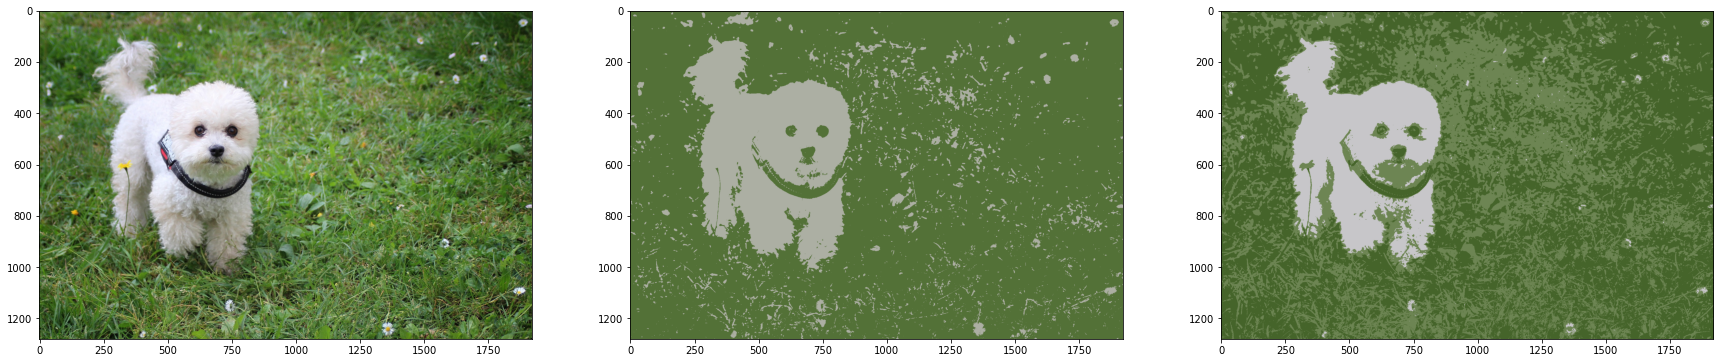

In [55]:
f, color = plt.subplots(1, 3, figsize=(30, 15))

color[0].imshow(convert_color(img_color))

for i in [2, 3]:
    clf = mixture.GaussianMixture(n_components=i, covariance_type='full')
    clf.fit(img_color_mod)
    label = clf.predict(img_color_mod)

    center = np.uint8(clf.means_)
    out = center[label.flatten()]
    color[i - 1].imshow(convert_color(out.reshape(img_color.shape)))

### Grayscale picture Expectation Maximization Segmentation

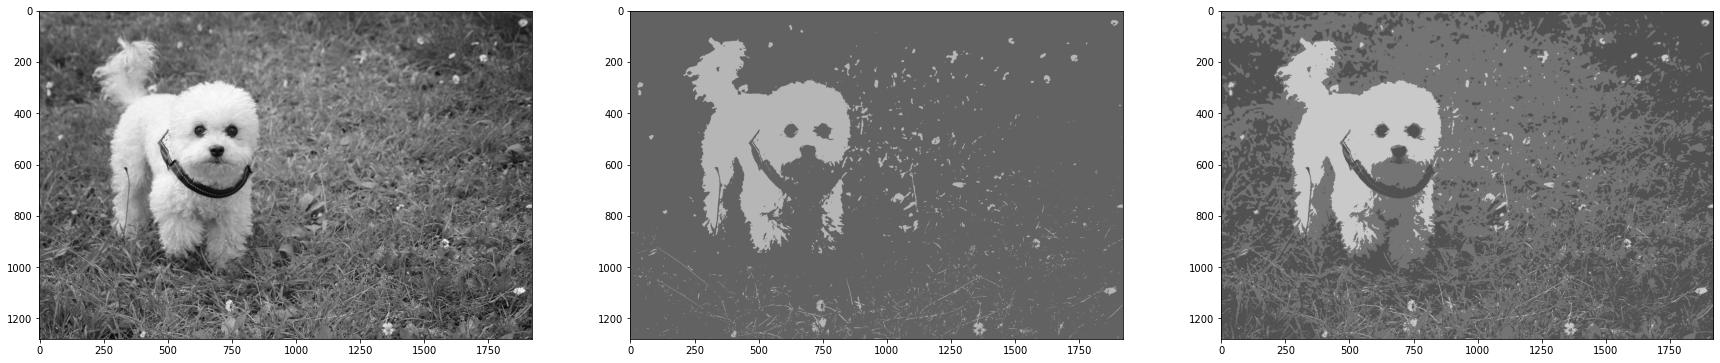

In [56]:
f, grey = plt.subplots(1, 3, figsize=(30, 15))

grey[0].imshow(img_grey, cmap='gray')

img_grey_mode_2D = img_grey_mod.reshape((img_grey_mod.shape[0], 1))

for i in [2, 3]:
    clf = mixture.GaussianMixture(n_components=i, covariance_type='full')
    clf.fit(img_grey_mode_2D)
    label = clf.predict(img_grey_mode_2D)

    center = np.uint8(clf.means_)
    out = center[label.flatten()]
    grey[i - 1].imshow(convert_color(out.reshape(img_grey.shape)), cmap='gray')

The color ouput had better results for the same reason as kmeans. This time, the k=3 gave better results, because there is less noise outside of the dog. There are a lot less white points other places on the image with k=3 than k=2.

### Mask-RCNN Segmentation

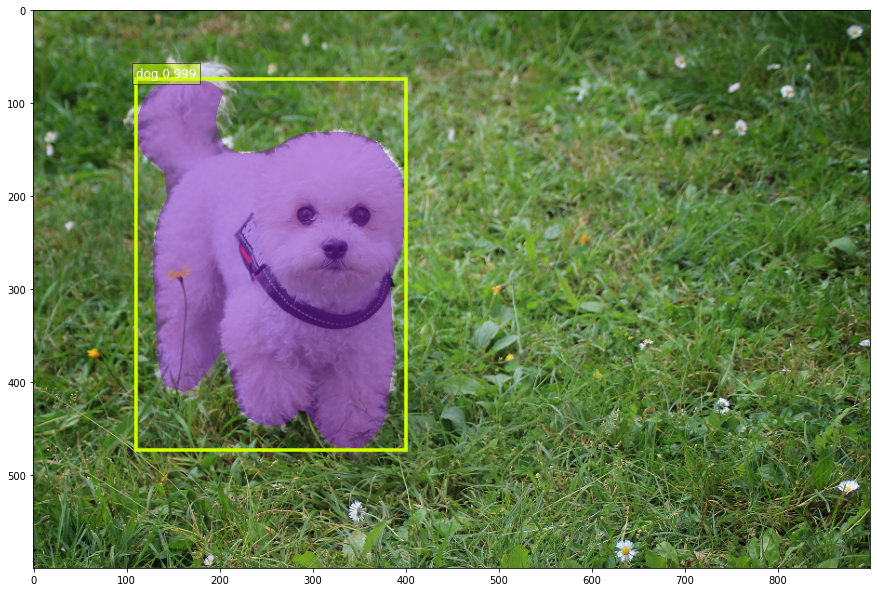

In [58]:
# downloading image
net = model_zoo.get_model('mask_rcnn_resnet50_v1b_coco', pretrained=True)

# preprocessing image
x, original_image = data.transforms.presets.rcnn.load_test(np.array([join(image_folder, 'poodle.jpg')]))

# inference
ids, scores, bboxes, masks = [xx[0].asnumpy() for xx in net(x)]
masks, _ = utils.viz.expand_mask(masks, bboxes, (original_image.shape[1], original_image.shape[0]), scores)
original_image = utils.viz.plot_mask(original_image, masks)

# display
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1)
ax = utils.viz.plot_bbox(original_image, bboxes, scores, ids, class_names=net.classes, ax=ax)